In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch

import sys
sys.path.append('../')
from core import integrators, distributions

In [3]:
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.light_palette((210, 90, 60), input="husl", n_colors=50))
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=50))
my_cmap = ListedColormap(sns.color_palette("RdBu_r", 50))
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

from matplotlib.colors import to_rgb, to_rgba

def scatter(x, y, color, alpha_arr, **kwarg):
    r, g, b = to_rgb(color)
    # r, g, b, _ = to_rgba(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    plt.scatter(x, y, c=color, **kwarg)

In [4]:
def iterate(x_0, v_0, n_f, n_b, beta):
    x = [x_0.clone()]
    v = [v_0.clone()]
    log_p = [(target.log_prob(x[0])+momentum.log_prob(v[0])).view([1,1])]
    log_det = [torch.zeros([1,1], device=device, dtype=torch.float)]

    i = 0
    for _ in range(n_f):
        _x, _v, _log_p, _log_det = integrators.leap_frog_forward(x[i], v[i], eps, target, momentum, beta)
        x.append(_x)
        v.append(_v)
        log_p.append(_log_p.reshape([1,1]))
        log_det.append(_log_det + log_det[i])
        i += 1

    i_0 = 0
    for _ in range(n_b):
        _x, _v, _log_p, _log_det = integrators.leap_frog_backward(x[0], v[0], eps, target, momentum, beta)
        x.insert(0, _x) 
        v.insert(0, _v)
        log_p.insert(0, _log_p.reshape([1,1]))
        log_det.insert(0, _log_det + log_det[0])
        i_0 += 1
    x = torch.stack(x, dim=2)
    v = torch.stack(v, dim=2)
    log_p = torch.stack(log_p, dim=2)
    log_p -= log_p.max()
    log_det = torch.stack(log_det, dim=2)
    log_weights = log_p + log_det
    weights = torch.exp(log_weights - torch.logsumexp(log_weights, dim=2, keepdim=True)).squeeze().numpy()
    samples = x.squeeze().numpy()
    return samples, weights, log_p, log_det, i_0

In [5]:
device = torch.device('cpu')
sigma = 1.0
target = distributions.Banana(device)
momentum = distributions.Normal(torch.zeros(target.dim, device=device), sigma, device)

In [6]:
x_grid = np.linspace(-10., 10., 1000)
y_grid = np.linspace(-6., 1., 1000)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
pdf = target.log_prob(torch.tensor(np.stack([x_grid, y_grid], axis=2).reshape([-1, 2])))
pdf = torch.exp(pdf).numpy().reshape([1000, 1000])

In [31]:
torch.manual_seed(1)
x_0 = torch.zeros([1,target.dim])
x_0[0,0], x_0[0,1] = 4.0, -4.0
v_0 = momentum.sample(1)
v_0[0,1]*=2
v_0[0,0]*=-1

eps = torch.tensor([2e-1])
n = 30

In [39]:
samples_1, weights_1, log_p_1, log_det_1, i_0_1 = iterate(x_0, v_0, n, 0, 1.0)
weights_1[-1] = 0.7
weights_1[:-1] = 0.0
samples_2, weights_2, log_p_2, log_det_2, i_0_2 = iterate(x_0, v_0, n-10, 10, 1.0)
samples_3, weights_3, log_p_3, log_det_3, i_0_3 = iterate(x_0, v_0, n, 15, 0.95)
max_w = max([weights_1.max(), weights_2.max(), weights_3.max()])

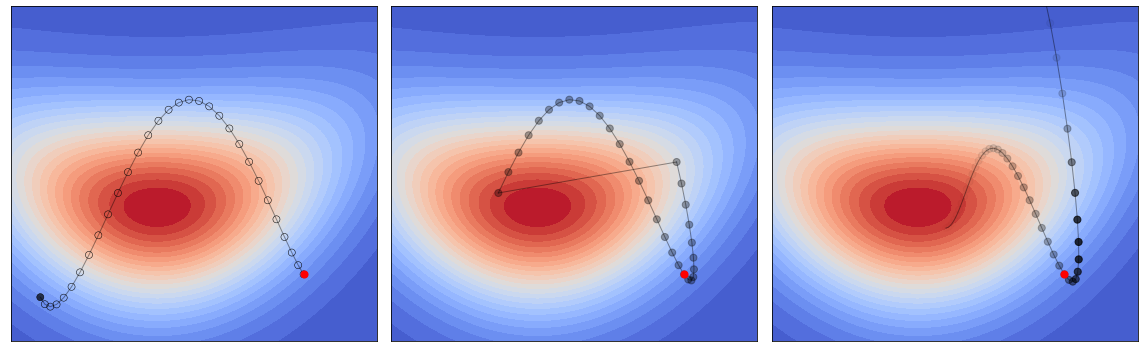

In [42]:
plt.figure(figsize(16,5), tight_layout=True)
plt.subplot(131)
plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)
plt.plot(samples_1[0], samples_1[1], c='black', lw=1, alpha=0.4)
scatter(samples_1[0], samples_1[1], 'black', weights_1, s=50, edgecolor='black', linewidth=0.5)
scatter(samples_1[0][i_0_1], samples_1[1][i_0_1], 'red', np.ones(1), s=50, zorder=5)
plt.xlim(-4.0,6.)
plt.ylim(-5.,0.)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)
plt.plot(samples_2[0], samples_2[1], c='black', lw=1, alpha=0.4)
plt.plot([samples_2[0][0], samples_2[0][-1]], [samples_2[1][0], samples_2[1][-1]], c='black', lw=1, alpha=0.4)
scatter(samples_2[0], samples_2[1], 'black', weights_2/0.1, s=50)
scatter(samples_2[0][i_0_2], samples_2[1][i_0_2], 'red', np.ones(1), s=50, zorder=5)
plt.xlim(-4.0,6.)
plt.ylim(-5.,0.)
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)
plt.plot(samples_3[0], samples_3[1], c='black', lw=1, alpha=0.4)
scatter(samples_3[0], samples_3[1], 'black', weights_3/0.1, s=50)
scatter(samples_3[0][i_0_3], samples_3[1][i_0_3], 'red', np.ones(1), s=50, zorder=5)
plt.xlim(-4.0,6.)
plt.ylim(-5.,0.)
plt.xticks([])
plt.yticks([])
plt.savefig('../pics/intro.png', bbox_inches='tight', transparent=True)
plt.show()